<a href="https://colab.research.google.com/github/rohang1411/Malaria-Parasite-Detection/blob/main/Malaria_Parasite_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Downloading the dataset - 

This is the publicly available malaria dataset provided by the National Library of Medicine and the NIH department

In [2]:
!wget ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip\
    -O /tmp/cell_images.zip

--2021-05-22 07:25:07--  ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/cell_images.zip
           => ‘/tmp/cell_images.zip’
Resolving lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)... 130.14.55.35, 2607:f220:41e:7055::35
Connecting to lhcftp.nlm.nih.gov (lhcftp.nlm.nih.gov)|130.14.55.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Open-Access-Datasets/Malaria ... done.
==> SIZE cell_images.zip ... 353452851
==> PASV ... done.    ==> RETR cell_images.zip ... done.
Length: 353452851 (337M) (unauthoritative)

cell_images.zip     100%[===================>] 337.08M  74.4MB/s    in 4.5s    

2021-05-22 07:25:12 (74.7 MB/s) - ‘/tmp/cell_images.zip’ saved [353452851]



Importing and extracting the dataset

In [3]:
import os
import zipfile
 
local_zip = '/tmp/cell_images.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/cell_images')
zip_ref.close()

In [4]:
os.listdir('/tmp/cell_images/cell_images')

['Uninfected', 'Parasitized']

In [5]:
train_para_dir = os.path.join('/tmp/cell_images/cell_images/Parasitized')

train_uninfected_dir = os.path.join('/tmp/cell_images/cell_images/Uninfected')

In [6]:
train_para_names = os.listdir(train_para_dir)
print(train_para_names[:3])

train_uninfected_names = os.listdir(train_uninfected_dir)
print(train_uninfected_names[:3])

['C82P43ThinF_IMG_20150817_123652_cell_219.png', 'C66P27N_ThinF_IMG_20150818_164754_cell_201.png', 'C99P60ThinF_IMG_20150918_141857_cell_9.png']
['C144P105ThinF_IMG_20151015_155004_cell_129.png', 'C39P4thinF_original_IMG_20150622_105253_cell_10.png', 'C80P41ThinF_IMG_20150817_111121_cell_123.png']


### Plotting the images

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

nrows = 4
ncols = 4
pic_index = 0

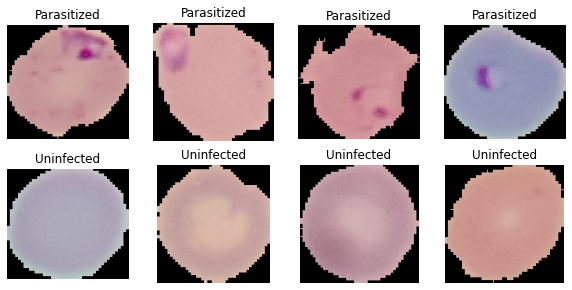

In [8]:

fig = plt.gcf()
fig.set_size_inches(10,10)

pic_index += 4
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-4:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-4:pic_index]]
count=0
for i, img_path in enumerate(next_horse_pix+next_human_pix):

  sp = plt.subplot(nrows, ncols, i + 1)
  count=count+1
  if count<=4:
    sp.set_title('Parasitized')
  else:
    sp.set_title('Uninfected')
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Training and Testing data

Used the ImageDataGenerator to automatically create training and testing batches

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
        '/tmp/cell_images/cell_images',  
        target_size=(100,100),  
        batch_size=512,
        class_mode='binary',
        subset='training')
validation_generator = train_datagen.flow_from_directory(
        '/tmp/cell_images/cell_images', 
        target_size=(100,100),  
        batch_size=512,
        class_mode='binary',
        subset='validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


In [10]:
import tensorflow as tf

## Model Architecture

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16928)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              17335296  
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

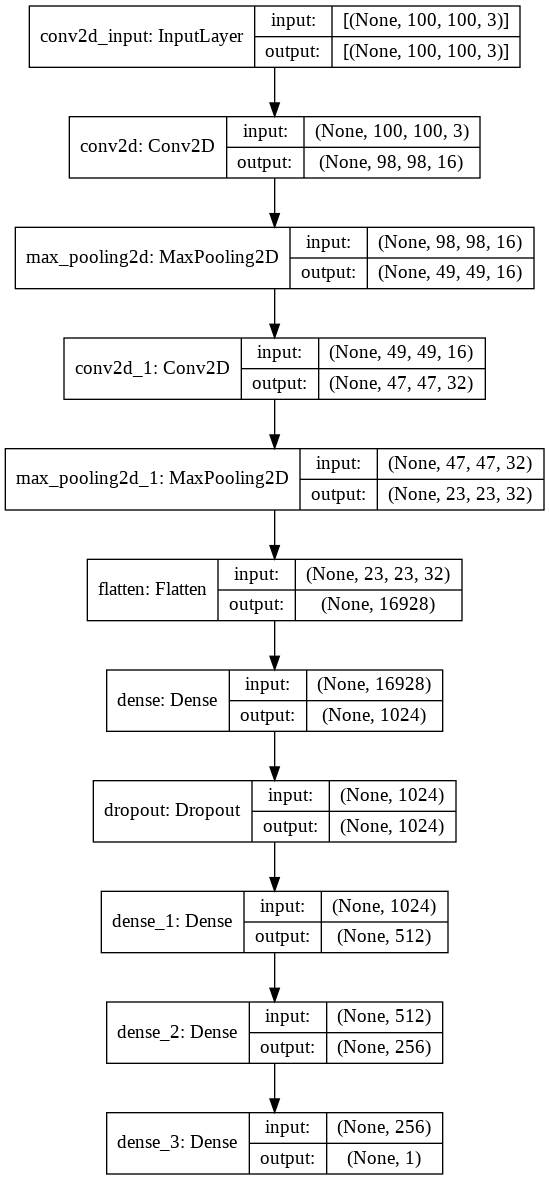

In [13]:
dot_img_file = '/content/sample_data/model_1.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

## Accuracy analysis of multiple optimizers

Used the 3 optimizers - RMSprop, SGD and Adam over 10 epochs and plotting their accuracy curves and finding the f1 score

RMSprop Optimizer

In [30]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
# model.compile(loss='binary_crossentropy',
#               optimizer=opt,
#               metrics=['accuracy'])

In [15]:
history = model.fit(
      train_generator,
      epochs=10,
      verbose=2,
      validation_data = validation_generator
      )

Epoch 1/10
44/44 - 59s - loss: 1.9377 - accuracy: 0.5432 - val_loss: 0.6818 - val_accuracy: 0.5336
Epoch 2/10
44/44 - 25s - loss: 0.6769 - accuracy: 0.5964 - val_loss: 0.6758 - val_accuracy: 0.6158
Epoch 3/10
44/44 - 25s - loss: 0.6307 - accuracy: 0.6548 - val_loss: 0.5970 - val_accuracy: 0.6998
Epoch 4/10
44/44 - 26s - loss: 0.5068 - accuracy: 0.7822 - val_loss: 0.2975 - val_accuracy: 0.8984
Epoch 5/10
44/44 - 25s - loss: 0.2623 - accuracy: 0.9042 - val_loss: 0.2133 - val_accuracy: 0.9240
Epoch 6/10
44/44 - 25s - loss: 0.1967 - accuracy: 0.9297 - val_loss: 0.2535 - val_accuracy: 0.8880
Epoch 7/10
44/44 - 25s - loss: 0.1715 - accuracy: 0.9438 - val_loss: 0.2173 - val_accuracy: 0.9064
Epoch 8/10
44/44 - 25s - loss: 0.1680 - accuracy: 0.9427 - val_loss: 0.6115 - val_accuracy: 0.9034
Epoch 9/10
44/44 - 25s - loss: 0.2045 - accuracy: 0.9194 - val_loss: 0.2523 - val_accuracy: 0.9214
Epoch 10/10
44/44 - 25s - loss: 0.1033 - accuracy: 0.9629 - val_loss: 0.2323 - val_accuracy: 0.9334


In [19]:
from sklearn.metrics import f1_score
import numpy as np

y_pred = model.predict_generator(generator=validation_generator)
y_pred = np.argmax(y_pred, axis=1)
f1_score(validation_generator.classes, y_pred, average='macro')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


0.3333333333333333

Text(0, 0.5, 'Accuracy')

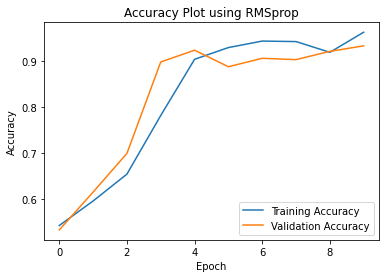

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],label='Training Accuracy')
plt.plot(history.history["val_accuracy"],label='Validation Accuracy')
plt.title("Accuracy Plot using RMSprop")
# plt.ylim(ymax = 1.1, ymin = 0.92)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Adam Optimizer

In [21]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
history = model.fit(
      train_generator,
      epochs=10,
      verbose=2,
      validation_data = validation_generator
      )

Epoch 1/10
44/44 - 26s - loss: 0.0760 - accuracy: 0.9759 - val_loss: 0.2632 - val_accuracy: 0.9270
Epoch 2/10
44/44 - 26s - loss: 0.0421 - accuracy: 0.9848 - val_loss: 0.3210 - val_accuracy: 0.9236
Epoch 3/10
44/44 - 25s - loss: 0.0319 - accuracy: 0.9880 - val_loss: 0.3029 - val_accuracy: 0.9321
Epoch 4/10
44/44 - 25s - loss: 0.0271 - accuracy: 0.9905 - val_loss: 0.3239 - val_accuracy: 0.9181
Epoch 5/10
44/44 - 25s - loss: 0.1030 - accuracy: 0.9677 - val_loss: 0.2734 - val_accuracy: 0.9152
Epoch 6/10
44/44 - 25s - loss: 0.0429 - accuracy: 0.9858 - val_loss: 0.3505 - val_accuracy: 0.9285
Epoch 7/10
44/44 - 25s - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.4677 - val_accuracy: 0.9234
Epoch 8/10
44/44 - 25s - loss: 0.0169 - accuracy: 0.9942 - val_loss: 0.4734 - val_accuracy: 0.9301
Epoch 9/10
44/44 - 25s - loss: 0.0120 - accuracy: 0.9963 - val_loss: 0.4560 - val_accuracy: 0.9221
Epoch 10/10
44/44 - 25s - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.4559 - val_accuracy: 0.9265


Text(0, 0.5, 'Accuracy')

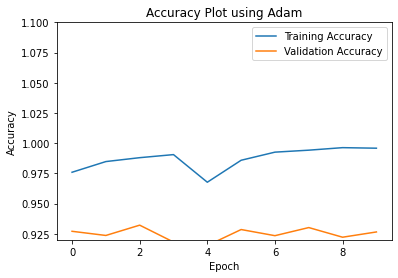

In [23]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],label='Training Accuracy')
plt.plot(history.history["val_accuracy"],label='Validation Accuracy')
plt.title("Accuracy Plot using Adam")
plt.ylim(ymax = 1.1, ymin = 0.92)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

SGD Optimizer

In [24]:
opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [25]:
history = model.fit(
      train_generator,
      epochs=10,
      verbose=2,
      validation_data = validation_generator
      )

Epoch 1/10
44/44 - 26s - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.5040 - val_accuracy: 0.9261
Epoch 2/10
44/44 - 25s - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.5062 - val_accuracy: 0.9274
Epoch 3/10
44/44 - 25s - loss: 0.0050 - accuracy: 0.9985 - val_loss: 0.5178 - val_accuracy: 0.9283
Epoch 4/10
44/44 - 25s - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.5242 - val_accuracy: 0.9294
Epoch 5/10
44/44 - 25s - loss: 0.0049 - accuracy: 0.9987 - val_loss: 0.5299 - val_accuracy: 0.9294
Epoch 6/10
44/44 - 25s - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.5237 - val_accuracy: 0.9296
Epoch 7/10
44/44 - 25s - loss: 0.0046 - accuracy: 0.9986 - val_loss: 0.5372 - val_accuracy: 0.9298
Epoch 8/10
44/44 - 25s - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.5338 - val_accuracy: 0.9298
Epoch 9/10
44/44 - 25s - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.5254 - val_accuracy: 0.9303
Epoch 10/10
44/44 - 25s - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.5176 - val_accuracy: 0.9299


Text(0, 0.5, 'Accuracy')

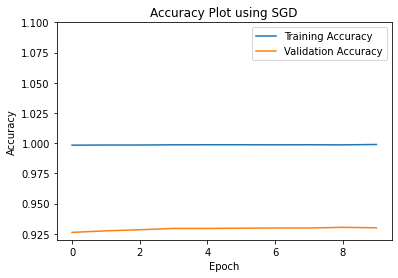

In [26]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"],label='Training Accuracy')
plt.plot(history.history["val_accuracy"],label='Validation Accuracy')
plt.title("Accuracy Plot using SGD")
plt.ylim(ymax = 1.1, ymin = 0.92)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

Visual representation of model layers

In [28]:
!pip install visualkeras

     |████████████████████████████████| 798kB 34.6MB/s 


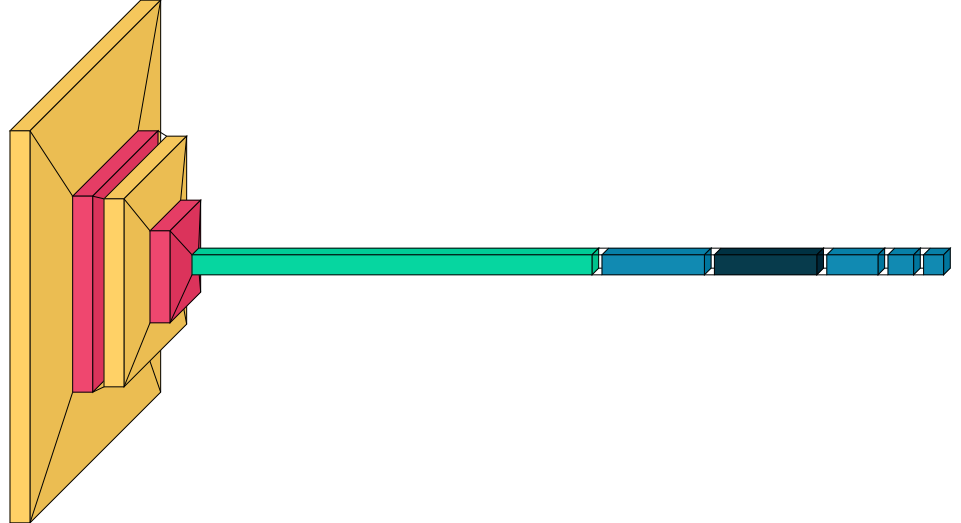

In [29]:
import visualkeras
visualkeras.layered_view(model)